# Parameter Estimation from ∆∆F

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
colors = mut.viz.personal_style()
constants = mut.thermo.load_constants()

# Load the data. 
data = pd.read_csv('../../data/csv/compiled_data.csv')

In this notebook, we try to use the empirically calculated difference in the free energy of binding as a target for parameter estimation. Here, we consider all of the single mutants (DNA binding domain and inducer binding domain) and test if different combinations of parameters can capture the phenomenology of the induction profiles. 

As we have derived, the difference between the empirically determined change in binding free energy relative to an arbitrarily chosen reference state can be calculated as

$$
\Delta F^* - \Delta F = k_BT \left[ \log{p_{act}(c) \over p_{act}^*(c)} - {\Delta\varepsilon_{RA}^* - \Delta\varepsilon_{RA}\over k_BT} \right] \tag{1}, 
$$

where $\Delta F^*$ is the empirically determined change in free energy of binding and $\Delta F$ is the difference in free energy of binding of the wild-type repressor relative to the reference state. 

I think there are characteristic profiles of deviation from the reference strain depending on which parameters change. Here, we examine this from a data based approach.

The choice of the reference state (as of this writing) is arbitrary, although I think we can get at this in a more meaningful manner. For simplicity, we can consider the reference state to have a DNA binding energy of $-13.9\, k_BT$ (that of the O2 operator), $R = 260$ (an arbitrary choice for historical reasons), and an inducer concentration of $c = 50\mu$M (approximately the [$EC_{50}$] for this strain). Below, we define these states and examine the range of the $\Delta F$ imposed by this choice of reference state. 

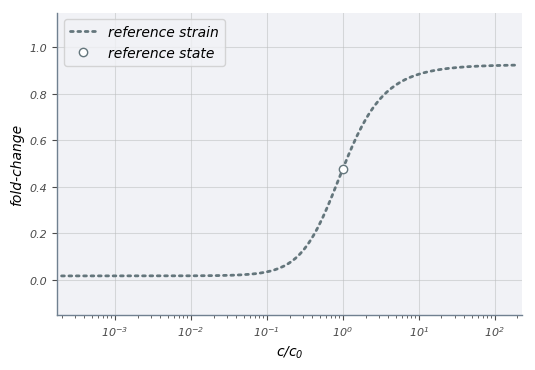

In [24]:
# Define the reference parameters. 
R0 = constants['RBS1027'] 
c0 = 50 # in µM
epRA = constants['O2']
ref_state = mut.thermo.SimpleRepression(R=R0, effector_conc=c0, 
                                       ep_r=epRA, ka=constants['Ka'],
                                       ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                       n_sites=constants['n_sites'])

# Define the reference strain (i.e. wild-typel)
c_range = np.logspace(-2, 4, 200) # in µM
ref_strain = mut.thermo.SimpleRepression(R=R0, effector_conc=c_range, 
                                       ep_r=epRA, ka=constants['Ka'],
                                       ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                       n_sites=constants['n_sites'])

# Instantiate the figure
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.set_xscale('log')
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('fold-change', fontsize=10)
ax.set_ylim([-0.15, 1.15])

# Plot the reference strain and state. 
ax.plot(c_range / c0, ref_strain.fold_change(), ':', lw=2, color=colors[0], 
           label='reference strain')
ax.plot(c0 / c0, ref_state.fold_change(), 'o', markerfacecolor='w', color=colors[0], 
           label='reference state')
ax.legend(fontsize=10)

## Part I: DNA Binding Domain Mutation

Given a mutation in the DNA binding domain, what biophysical parameters are changed? Is it *only* the DNA binding energy, or do other biophysical parameters change in response? Here, we have three differen mutations in the DNA binding domain (Y20I, Q21A, and Q21M) which alter *at least* the affinity of the repressor to the DNA.  

To begin, we can examine induction profiles relative to the reference state and strain shown above

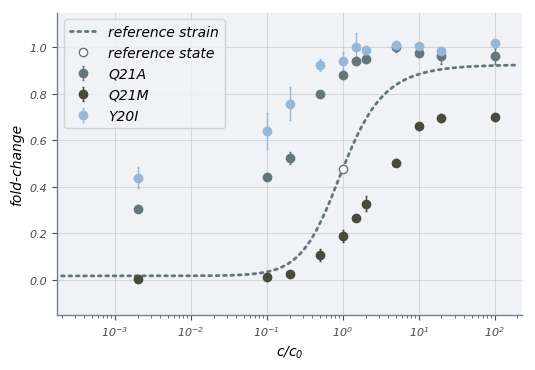

In [26]:
# Isolate the data to DNA binding mutations
DNA = data[(data['class']=='DNA') & (data['operator']=='O2') &
          (data['repressors']==260)].copy()

# Group them by IPTG and compute the aggregate props. 
grouped = DNA.groupby(['mutant', 'IPTGuM']).agg(('mean', 'sem')).reset_index()

# Instantiate the figure
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.set_xscale('log')
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('fold-change', fontsize=10)
ax.set_ylim([-0.15, 1.15])

# Plot the reference strain and state. 
ax.plot(c_range / c0, ref_strain.fold_change(), ':', lw=2, color=colors[0], 
           label='reference strain')
ax.plot(c0 / c0, ref_state.fold_change(), 'o', markerfacecolor='w', color=colors[0], 
           label='reference state')
for g, d in grouped.groupby('mutant'):
    ax.errorbar(d['IPTGuM']/c0, d['fold_change']['mean'], d['fold_change']['sem'],
               fmt='o', linestyle='none', lw=1, capsize=1, label=g)
ax.legend(fontsize=10)

# 